# Not Another Dimensionality Reduction Tutorial

Matt Stone  
30 Nov 2019

## 1. Introduction

Dimensionality reduction considers the problem of simplifying high-dimensional data to a smaller, more tractable space. A common source of high-dimensional data in quantitative biology is single-cell RNA-sequencing. Each experiment reports the expression of thousands of genes in thousands of cells. In this context, each cell is an _observation_ with thousands of _features_ - the gene expression measurements. Although these thousand-dimensional vectors are not tractable to work with directly, by reducing their dimensionality we can visualize the cells in two dimensions or improve the performance of analyses such as clustering.

## 2. Background

Dimensionality reduction has two primary applications - visualization and clustering.

We often want to visualize our data to determine if there are any interesting relationships in our data. However, when creating visualizations we're generally limited to two dimensions. If our data points are of a higher dimension, we can't plot them directly, and instead want to find a corresponding 2-D point that is a "good-enough" approximation of the original high-dimensional vector. Ideally, we want to find a 2-D approximation that preserves most of the structure in the original data. That is, if two points are near by each other in the original high-dimensional space, we'd like them to remain near each other in 2-D space so we can "see" their similarity. 

Let's look at a simple 3D example. Suppose our data consists of two rings, one floating above the other. 

<center><img src='figs/circles.png' height=400></center>

If we rotate the data around a bit while staying in 3D space, we can see that it should be possible to separate the points from each other. Specifically, if we look at these data from the front or the side, we can see that the data exists in two "layers", while if we look at the the data from the top, we can see the two circles.

<center><img src='figs/circles_rotated.png' height=400></center>

This hopefully provides some intuition for _linear_ dimensionality reduction. In general, we choose some plane in 2D space, and project each data point onto the nearest point in this plane. 

Here, a very simple linear algorithm is to choose two of our coordinates to keep (X and Y) and one to discard (Z). This preserves the circular structure of the red and blue clusters, although we lose the information we had about how far apart these data were vertically. 

<center><img src='figs/projection.png' height=400></center>

Visualization can be helpful when trying to explore some algorithmic result. For example, if we picked a "bad" plane here


when evaluating the Garnett algorithm, the authors created a figure of the cells colored by their cell type assignments in order to demonstrate that the cell types roughly corresponded to visible clusters in the data, and that these pre-existing clusters had coherent assignments. (TODO: 

This brings us to our second application - clustering. When we visualize our data in 2-D space, we often observe some visible structure, or grouping of our data points. There are many algorithms which formalize the problem of identifying clusters in a dataset. However, these algorithms require some quantifiable measure of similarity between data points. Typically, this is Euclidean distance (i.e. the L2-norm we discussed in class, $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$). However, traditional distance doesn't behave as expected in high dimensions - distances generally end up being quite large and all points look far away from each other. We can therefore use dimensionality reduction as a preprocessing step before applying a clustering algorithm. We don't have to reduce all the way to two dimensions, but we can choose an intermediate size (20-30 dimensions) where distance metrics behave reasonably well. 

Preserving structure is especially important when considering dimensionality reduction algorithms for clustering. We want to preserve both local distances (whether two points are similar) and global distances (whether two clusters are similar) in order to accurately analyze any structure in our dataset.

## 3. Dimensionality reduction algorithms


### 3.1 Principal components analysis (PCA)

PCA is a very common and popular dimensionality reduction technique. It is a _linear_ reduction algorithm, which means that it chooses some plane 
Historically, dimensionality reduction was often performed using principal components analysis (PCA). This algorithm identifies the vector through the data which captures the most possible variance when points are projected onto it, then finds an orthogonal vector with captures the next most possible variance, and so on. Intuitively, if your data are Gaussian and in an ellipsoid shape, PCA will identify first the major axis and then the minor axis of the ellipsis.

Two more recent algorithms that are especially popular in single-cell applications are t-SNE (t-distributed stochastic neighbor embedding) and UMAP (uniform manifold approximation and projection).

The t-SNE algorithm assumes that a data point and its neighbors are drawn from a $t$-distribution, and tries to learn the parameters of a 2-dimensional distribution that most closely approximates the high-dimensional distribution. More formally, it minimizes the Kullback-Leibler divergence between these two distributions. 

The UMAP algorithm builds a nearest-neighbor graph from the high dimensional data, and tries to learn a low-dimensional embedding whose nearest-neighbor graph has a similar topology. More formally, the algorithm normalizes distances for the nearest-neighbor graph based on how far away a point is from its nearest neighbor, and minimizes something called cross entropy between the topology of the high and low dimensional graphs.

TODO: flesh out the mathematical intuition here, add figures

## 4. Demonstration of PCA, t-SNE, and UMAP

In [3]:
import pandas as pd

### Example data &mdash; Tran et al.

To demonstrate these dimensionality reduction techniques, I'll be using single-cell RNA-seq data from a recent study of reprogramming mouse iPSC lines published by [Tran et al.](https://www.cell.com/cell-reports/fulltext/S2211-1247(19)30529-7) (GEO accession [GSE108222](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE108222)). 

This matrix contains expression levels of 6,618 genes in 2,369 cells, sampled at 4 timepoints with 2 replicate cell lines. The expression data has previously been depth-normalized and square-root transformed, so we will work with the example matrix directly. 

We can take a quick look at the first few lines and columns of the matrix to get a sense for what the data looks like. The rows are labeled with gene names, and the columns are labeled with cell IDs, which include the timepoint (e.g. MEF Day0 Rep1) and the unique molecular identifier (UMI) for the droplet.

In [2]:
expr = pd.read_csv('data/sridharan_A2S.csv.gz', index_col=0)    # Load expression matrix as Pandas dataframe
print(expr.shape)                                          # Print number of rows and columns
expr.iloc[:5, :3]                                          # Display first 5 rows and first 3 columns

(6618, 2369)


,MEFDay0Rep1_gctgaggtacaggagctt,MEFDay0Rep1_atagcgcggtccacccaa,MEFDay0Rep1_tgcggtgaaatagctccc
Gene,,,
1110004E09Rik,0.508184,0.625024,0.447522
1110051M20Rik,0.000000,0.625024,0.000000
2210016L21Rik,0.803510,0.765495,1.184033
2300002M23Rik,0.000000,0.000000,0.000000
2900026A02Rik,0.803510,0.625024,0.447522


We can also view the full expression matrix as a heatmap to get a sense of what the data looks like. We can see that some genes (rows) are expressed in most cells (bright yellow rows), and the data is generally somewhat noisy (even high expressed genes have empty values in some cells, overall the matrix looks sparse or dotty).

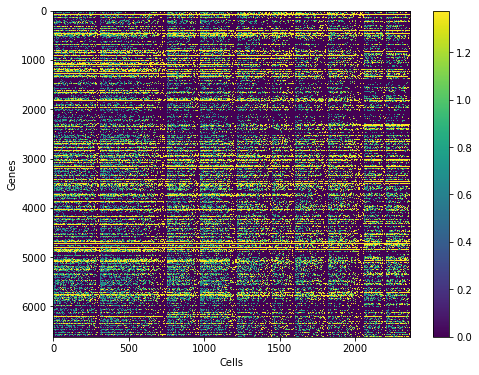

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))          # Create a matplotlib figure with 1 plot

im = ax.imshow(expr.values,                           # Plot a heatmap on the figure
               aspect='auto',                         # Scale the heatmap to the size of the figure
               vmin=0,                                # Color scale starts at 0
               vmax=np.quantile(expr.values, 0.9),    # Color scale ends at 90th pctile (clip high-expressed genes)
               cmap='viridis')                        # Use a perceptually uniform color map

ax.set_xlabel("Cells")
ax.set_ylabel("Genes")
ax.figure.colorbar(im)                                # Show range of values corresponding to color scale

### PCA

Let's start by obtaining a PCA of our expression data. We will use the [scikit-learn](https://scikit-learn.org/stable/index.html) implementation (full documentation available [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)).

In [4]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)    # Create a PCA object/model
pca.fit(expr.T)                            # Fit the PCA model to our expression matrix
                                           #  (Note that we transpose the matrix so genes are features)
pca_embedding = pca.transform(expr.T)      # Reduce the expression matrix to the top 2 components

Let's walk through this code. 

Scikit-learn algorithms are generally provided as methods to _classes_. We first instantiate a PCA object, or model, with the desired parameters. Here, we are only specifying the argument `n_components`, which tells the model the number of dimensions we want to reduce to.

```
pca = decomposition.PCA(n_components=2)
```

Next, we want to fit the model to our data. Scikit-learn objects generally have a `fit` method that takes a matrix of data. Remember that our expression matrix `expr` has genes as rows and cells as columns. Scikit-learn algorithms assume that rows correspond to observations and columns correspond to features (or variables), so we transpose our matrix before fitting the model.
```
pca.fit(expr.T)
```

Finally, we want to transform our data. Again, Scikit-learn objects have a general method called `transform` that handles this for us, and we want to transpose our (genes x cells) matrix before transformation. 
```
pca_embedding = pca.transform(expr.T)
```

And, if we look at the dimensions of our matrices, we can see that our PCA has successfully reduced the raw expression data from 6,618 dimensions (number of genes) to 2 dimensions (principal components).

In [5]:
print(expr.T.shape)
print(pca_embedding.shape)

(2369, 6618)
(2369, 2)


Now, we can view our cells in a 2-dimensional scatter plot. Here, every point in the scatter plot is a cell, the x-axis corresponds to the first principal component, and the y-axis corresponds to the second.

Text(0, 0.5, 'PC2')

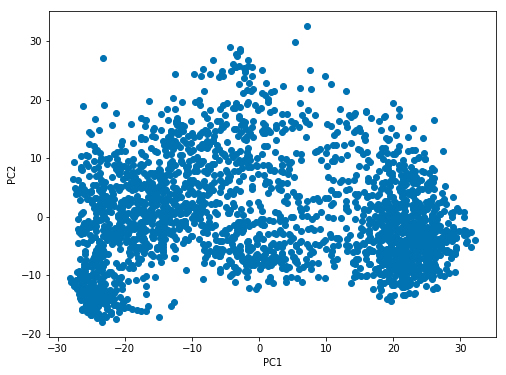

In [6]:
fig, ax = plt.subplots(1, 1, 
                       figsize=(8, 6))    

ax.scatter(pca_embedding[:, 0],           # Scatter plot (x-values first)
           pca_embedding[:, 1])           # y-values

ax.set_xlabel('PC1')                      # Label axes with first/second principal components
ax.set_ylabel('PC2')

But this is kind of a boring figure. Generally, we want to reduce the dimensionality of our data so we can visualize some feature of interest across the cells. For example, here we could color the cells based on their timepoint/cell type (ignoring cell line replicates for now).

We'll load a table that includes these labels:

In [9]:
pdata = pd.read_table('data/pheno_data.cell_filtered.txt', index_col=0)
pdata.head()

,Timepoint:Replicate,Timepoint,Replicate
MEFDay0Rep1_gctgaggtacaggagctt,MEFDay0Rep1,MEFDay0,Rep1
MEFDay0Rep1_atagcgcggtccacccaa,MEFDay0Rep1,MEFDay0,Rep1
MEFDay0Rep1_tgcggtgaaatagctccc,MEFDay0Rep1,MEFDay0,Rep1
MEFDay0Rep1_ggattggccagagtcggc,MEFDay0Rep1,MEFDay0,Rep1
MEFDay0Rep1_gatcaagtcggcgtttca,MEFDay0Rep1,MEFDay0,Rep1


And then we'll make another scatter plot where each timepoint is colored separately.

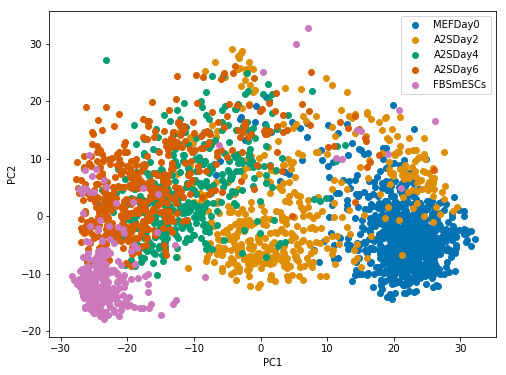

In [8]:
# Figure setup
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    # Figure with one plot again
palette = sns.color_palette('colorblind')       # Keep it colorblind-friendly!

# Scatter plots - we plot the cells from each timepoint separately
# so we can give them different colors and labels
for i, timepoint in enumerate(pdata.Timepoint.unique()):
    idx = np.where(pdata.Timepoint == timepoint)    # Get the indices of the cells at the given timepoint
    ax.scatter(pca_embedding[idx, 0],               # First component of the current cells (x-values)
               pca_embedding[idx, 1],               # Second component of the current cells (y-values)
               c=[palette[i]],                      # Palette is list of colors - cycle through with each timepoint
               label=timepoint)                     # Label each group of cells with timepoint - for legend

# Label axes with first/second principal components
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# Matplotlib automagically makes legend based on labels provided above
ax.legend()                                

This is more interesting! We can start seeing a temporal progression from the initial fibroblasts on the right, through the sampled timepoints of the differentiating cells, ending with "final" embryonic stem cells on the left.

### Cleaner code

Before moving on to the other sections, I am going to introduce two shortcuts for the above code that will be useful as we look at the other algorithms.

The first shortcut is the `fit_transform` method. Like the `fit` and `transform` methods, it's available in most Scikit-learn objects, and it is a convenience method that combines model fitting and transformation into one step. It takes the data matrix like the other functions, fits the model to the data, and returns the transformed data.

In [9]:
pca = decomposition.PCA(n_components=2)      # Create a PCA object/model
pca_embedding = pca.fit_transform(expr.T)    # Fit the model and transform the expression matrix

The second shortcut is that we don't have to store the PCA model in its own variable. We can simply instantiate the model and then call `fit_transform` on it directly. This idea of "chaining" methods is common in the Python data science stack and you will often see it applied to Numpy arrays, Pandas DataFrames, or Scikit-learn pipelines. 

So we can reduce our dimensionality reduction to a single line of code:

In [10]:
pca_embedding = decomposition.PCA(n_components=2).fit_transform(expr.T)

### t-SNE

We will use [scikit-learn's](https://scikit-learn.org/stable/index.html) implementation of t-SNE. The full documentation for their implementation is available [here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

Obtaining a t-SNE embedding of the cells is relatively straightforward, with only a few lines of code:

In [ ]:
from sklearn import manifold
from sklearn import decomposition

pca_intermediate = decomposition.PCA(n_components=30).fit_transform(expr.T)
tSNE_embedding = manifold.TSNE(n_components=2).fit_transform(pca_intermediate)

Let's walk through these two lines of code. 

The first should be familiar from our use of PCA in the last section. We're using PCA to reduce the raw expression to the top 30 principal components.

In the second line, instead of using the `decomposition.PCA` class to run a PCA, we're using Scikit-learn's `manifold.TSNE` class to run t-SNE. Note that besides the different class, the syntax is otherwise the same &ndash; we need to specify `n_components` and can use the `fit_transform` method.

Now, why are we running a PCA before t-SNE? The t-SNE algorithm is relatively slow, so it's recommended to "partially" reduce the dimensions with another algorithm, such as PCA, before applying t-SNE. Here, we are using PCA to reduce our expression data to the top 30 principal components, and then applying t-SNE to this (2369 x 30) matrix.

And again we can sanity check our dimensions to confirm that we have two dimensions for each of our 2,369 cells:

In [ ]:
print(expr.T.shape)
print(pca_intermediate.shape)
print(tSNE_embedding.shape)

Now, we'll plot the t-SNE embedding of our points using the same code as above. The only difference is that we are now using the t-SNE coordinates instead of the PCA coordinates.

In [ ]:
# Figure setup
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    # Figure with one plot again
palette = sns.color_palette('colorblind')       # Keep it colorblind-friendly!

# Scatter plots - we plot the cells from each timepoint separately
# so we can give them different colors and labels
for i, timepoint in enumerate(pdata.Timepoint.unique()):
    idx = np.where(pdata.Timepoint == timepoint)    # Get the indices of the cells at the given timepoint
    ax.scatter(tSNE_embedding[idx, 0],              # First component of the current cells (x-values)
               tSNE_embedding[idx, 1],              # Second component of the current cells (y-values)
               c=[palette[i]],                      # Palette is list of colors - cycle through with each timepoint
               label=timepoint)                     # Label each group of cells with timepoint - for legend

# Label axes with first/second components
ax.set_xlabel('tSNE1')
ax.set_ylabel('tSNE2')

# Matplotlib automagically makes legend based on labels provided above
ax.legend()                                

### UMAP

Finally, we'll try using UMAP. UMAP is not packaged with scikit-learn like the other algorithms, but is available as [its own package](https://umap-learn.readthedocs.io/en/latest/).

In [ ]:
import umap

umap_embedding = umap.UMAP(n_components=2, random_state=149).fit_transform(expr.T)

Even though UMAP is a separate package from scikit-learn, the syntax is compatible with the scikit-learn classes we've seen so far. We create a `umap.UMAP` class, specifying that we want to reduce to two dimensions, and then we call `fit_transform` on the expression matrix to obtain the 2-D embedding.

Note the additional argument `random_state`. UMAP is a stochastic, not deterministic, algorithm, so its output can change from run to run. By setting a fixed random state (equivalent to R's `set.seed`), we can keep its output reproducible.

Again we sanity check our dimensions:

In [ ]:
print(expr.T.shape)
print(umap_embedding.shape)

And plot the embedding:

In [ ]:
# Figure setup
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    # Figure with one plot again
palette = sns.color_palette('colorblind')       # Keep it colorblind-friendly!

# Scatter plots - we plot the cells from each timepoint separately
# so we can give them different colors and labels
for i, timepoint in enumerate(pdata.Timepoint.unique()):
    idx = np.where(pdata.Timepoint == timepoint)    # Get the indices of the cells at the given timepoint
    ax.scatter(umap_embedding[idx, 0],              # First component of the current cells (x-values)
               umap_embedding[idx, 1],              # Second component of the current cells (y-values)
               c=[palette[i]],                      # Palette is list of colors - cycle through with each timepoint
               label=timepoint)                     # Label each group of cells with timepoint - for legend

# Label axes with first/second components
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

# Matplotlib automagically makes legend based on labels provided above
ax.legend()                                

### PHATE

In [62]:
import phate

phate_embedding = phate.PHATE(n_components=2, random_state=149, verbose=False).fit_transform(expr.T)

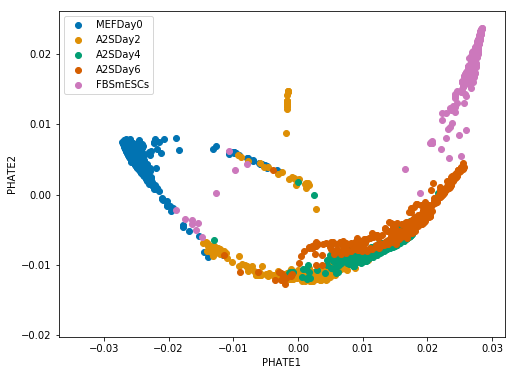

In [11]:
# Figure setup
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    # Figure with one plot again
palette = sns.color_palette('colorblind')       # Keep it colorblind-friendly!

# Scatter plots - we plot the cells from each timepoint separately
# so we can give them different colors and labels
for i, timepoint in enumerate(pdata.Timepoint.unique()):
    idx = np.where(pdata.Timepoint == timepoint)    # Get the indices of the cells at the given timepoint
    ax.scatter(phate_embedding[idx, 0],              # First component of the current cells (x-values)
               phate_embedding[idx, 1],              # Second component of the current cells (y-values)
               c=[palette[i]],                      # Palette is list of colors - cycle through with each timepoint
               label=timepoint)                     # Label each group of cells with timepoint - for legend

# Label axes with first/second components
ax.set_xlabel('PHATE1')
ax.set_ylabel('PHATE2')

# Matplotlib automagically makes legend based on labels provided above
ax.legend()                                

## 5. TODOs for final draft

- Flesh out mathematical intuition
- Add examples of clustering algorithms
- Add examples on 10X PBMC data to tie back to Garnett discussion (much larger dataset so algorithms are slower)
- Add ISOMAP, Laplacian Eigenmaps - maybe introduce relationship with UMAP
- Expand on other parameters that each algorithm takes, show examples of what happens when we change them
- CITATIONS
- Reorganize code above to minimize redundancy